# Approach :

1. Using Asymmetric Semantic Search (where the `query` size and `data_corpus` size is different), to find the similarity between given data and the query.

 **Semantic Search** - The idea behind semantic search is to embed all entries in your corpus, which can be sentences, paragraphs, or documents, into a vector space. At search time, the query is embedded into the same vector space and the closest embedding from your corpus is found.


 2. Model Used - `msmarco-distilbert-base-dot-prod-v3` which uses dot product to find the similarity.

 3. Encodings and storing them - **FAISS**: (Facebook AI Similarity Search) is a library that allows developers to quickly search for embeddings of multimedia documents that are similar to each other.

 4. Summarizer : Used the `Hugging Face Pipeline` for the summarization with its default model (sshleifer/distilbart-cnn-12-6). However dedicated summarizer can be implemented to increase the efficiency and time optimization

 5. Finally saving the output to a ".txt" file



# Semantic Search

In [ ]:
!pip install faiss-gpu
!pip install transformers
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.9 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=a17c76ae298fd2831ef82050ff8c3b7f623ecccbc0263897cb9a86541693663e
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
#importing all the necessary libraries
import json
import numpy as np
import pandas as pd
import faiss
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time
import transformers
from transformers import pipeline


In [ ]:
#Laoding Data and its analysis

# Path to the Dataset file
file_path = '/content/drive/MyDrive/sus.json'

# Load the JSON data
with open(file_path, 'r') as file:
    data = json.load(file)


for i in data.items():
  # i -> tuple
  # i[0] -> Doc_ids
  # i[1] -> Content
  print(len(i[1]))
  break

66


In [ ]:
# Converting the data to Dataframes
"""
The given data is in json format -> Dictionary
keys : Doc_ids (Beyoncé , Fredrick chopin etc.)
       Content -> List of Paragraphs (No of Paragraphs -> 66 for Beyonce, 82 for Fredrick Chopin etc)

Converting the Content data into a dataframe for ease of analysing and manipulation
df -> Dataframe with each row entry as the text material
"""
#making a empty dataframe
df = pd.DataFrame()

for i in data.items():
  df = df.append(i[1])

<ipython-input-5-e878f53167c3>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(i[1])
<ipython-input-5-e878f53167c3>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(i[1])
<ipython-input-5-e878f53167c3>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(i[1])
<ipython-input-5-e878f53167c3>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(i[1])
<ipython-input-5-e878f53167c3>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(i[1])
<ipython-input-5-e878f53167c3>:14: FutureWarn

In [ ]:
#df.head(100)

#Resetting the index of the dataframe
df.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')

,index,0
0,0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
1,1,Following the disbandment of Destiny's Child i...
2,2,"A self-described ""modern-day feminist"", Beyonc..."
3,3,"Beyoncé Giselle Knowles was born in Houston, T..."
4,4,Beyoncé attended St. Mary's Elementary School ...
...,...,...
19030,24,Isaac Newton (1643–1727) inherited Descartes' ...
19031,25,"There is an entire literature concerning the ""..."
19032,26,In the late 19th century with the discovery of...
19033,27,These quarks and leptons interact through four...


<ipython-input-7-a68f9e359383>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['doc_len'], hist=True, kde=True, color='b', label='doc len')


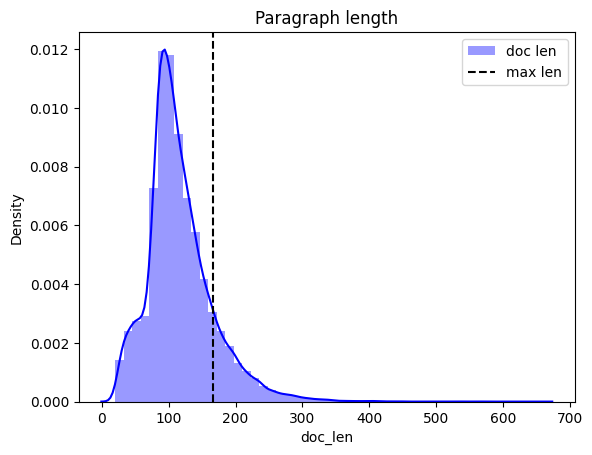

In [ ]:
# To see how long this text information is

df['doc_len'] = df[0].apply(lambda words: len(words.split()))

max_seq_len = np.round(df['doc_len'].mean() + df['doc_len'].std()).astype(int)

sns.distplot(df['doc_len'], hist=True, kde=True, color='b', label='doc len')

plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('Paragraph length'); plt.legend()
plt.show()

In [ ]:
#Model

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')

In [ ]:
#Encoding each paragraph to a 768-dimensional vector and stored to disk with content.index

#FAISS is a library for efficient similarity search and clustering of dense vectors.
import faiss

encoded_data = model.encode(df[0].tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))

index = faiss.IndexIDMap(faiss.IndexFlatIP(768))

#Used index.add_with_ids to encode the data in the order of data-frame and stores their index ids too.
index.add_with_ids(encoded_data, np.array(range(0, len(df))))

faiss.write_index(index, 'content.index')

In [ ]:
#helper functions

#used to map back to our dataframe so that we can summarize it
def fetch_info(dataframe_idx):
    info = df.iloc[dataframe_idx]
    meta_dict = dict()
    meta_dict['Content'] = info[0]

    return meta_dict

"""
query -> User entered query
top_k -> number of results to be returned
model -> sbert
index -> faiss_index
"""

def search(query, top_k, index, model):
    t=time.time()
    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)
    print('>>>> Results in Total Time: {}'.format(time.time()-t))
    top_k_ids = top_k[1].tolist()[0]
    top_k_ids = list(np.unique(top_k_ids))
    results =  [fetch_info(idx) for idx in top_k_ids]
    return results

In [ ]:
#Taking User Input for the Query

query = input("Ask what shall you seek? : ")

Ask what shall you seek? : What is Hyderabad famous for?


In [ ]:
#Importing pretty print
from pprint import pprint

results=search(query, top_k=3, index=index, model=model)
print("\n")
for result in results:
    print('\t',result)
    print(type(result))

>>>> Results in Total Time: 0.06200456619262695


	 {'Content': "Hyderabad (i/ˈhaɪdərəˌbæd/ HY-dər-ə-bad; often /ˈhaɪdrəˌbæd/) is the capital of the southern Indian state of Telangana and de jure capital of Andhra Pradesh.[A] Occupying 650 square kilometres (250 sq mi) along the banks of the Musi River, it has a population of about 6.7 million and a metropolitan population of about 7.75 million, making it the fourth most populous city and sixth most populous urban agglomeration in India. At an average altitude of 542 metres (1,778 ft), much of Hyderabad is situated on hilly terrain around artificial lakes, including Hussain Sagar—predating the city's founding—north of the city centre."}
<class 'dict'>
	 {'Content': 'Hyderabad was historically known as a pearl and diamond trading centre, and it continues to be known as the City of Pearls. Many of the city\'s traditional bazaars, including Laad Bazaar, Begum Bazaar and Sultan Bazaar, have remained open for centuries. However, industriali

In [ ]:
#Adding the search results (most similiar from the text corpus) according to the user query to a list

#these will be the input of the summarizer
inputs = []

for result in results:
    inputs.append(result.get("Content"))

In [ ]:
inputs

["Hyderabad (i/ˈhaɪdərəˌbæd/ HY-dər-ə-bad; often /ˈhaɪdrəˌbæd/) is the capital of the southern Indian state of Telangana and de jure capital of Andhra Pradesh.[A] Occupying 650 square kilometres (250 sq mi) along the banks of the Musi River, it has a population of about 6.7 million and a metropolitan population of about 7.75 million, making it the fourth most populous city and sixth most populous urban agglomeration in India. At an average altitude of 542 metres (1,778 ft), much of Hyderabad is situated on hilly terrain around artificial lakes, including Hussain Sagar—predating the city's founding—north of the city centre.",
 'Hyderabad was historically known as a pearl and diamond trading centre, and it continues to be known as the City of Pearls. Many of the city\'s traditional bazaars, including Laad Bazaar, Begum Bazaar and Sultan Bazaar, have remained open for centuries. However, industrialisation throughout the 20th century attracted major Indian manufacturing, research and finan

# Summarization


In [ ]:
#initializing the huggingface pipeline
summarization_pipeline = transformers.pipeline("summarization")

#generating summary
output = summarization_pipeline(inputs)

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
output

[{'summary_text': ' Hyderabad is the capital of the southern Indian state of Telangana and de jure capital of Andhra Pradesh . Occupying 650 square kilometres (250 sq mi) along the banks of the Musi River, it has a population of 6.7 million and a metropolitan population of 7.75 million .'},
 {'summary_text': " Hyderabad was historically known as a pearl and diamond trading centre . Special economic zones dedicated to information technology have encouraged companies from across India and around the world to set up operations . With an output of US$74 billion, Hyderabad is the fifth-largest contributor to India's overall gross domestic product ."},
 {'summary_text': ' Hyderabad is 1,566 kilometres (973 mi) south of Delhi, 699 kilometres (434 mi) southeast of Mumbai, and 570 kilometres (350 mi) north of Bangalore by road . It lies on the banks of the Musi River, in the northern part of the Deccan Plateau . The city has 140 lakes and 834 water tanks (ponds)'}]

In [ ]:
# Initialize an empty string to store the concatenated summaries
concatenated_summary = ""

# Iterate through the list of dictionaries and concatenate summaries
for sum_dict in output :
    summary_text = sum_dict.get('summary_text', '')  # Get the 'summary_text' value from each dictionary
    concatenated_summary += summary_text + " "  # Concatenation

print(concatenated_summary)

 Hyderabad is the capital of the southern Indian state of Telangana and de jure capital of Andhra Pradesh . Occupying 650 square kilometres (250 sq mi) along the banks of the Musi River, it has a population of 6.7 million and a metropolitan population of 7.75 million .  Hyderabad was historically known as a pearl and diamond trading centre . Special economic zones dedicated to information technology have encouraged companies from across India and around the world to set up operations . With an output of US$74 billion, Hyderabad is the fifth-largest contributor to India's overall gross domestic product .  Hyderabad is 1,566 kilometres (973 mi) south of Delhi, 699 kilometres (434 mi) southeast of Mumbai, and 570 kilometres (350 mi) north of Bangalore by road . It lies on the banks of the Musi River, in the northern part of the Deccan Plateau . The city has 140 lakes and 834 water tanks (ponds) 


In [ ]:
#writing the output to a .txt file

#open text file
sum_file = open("/content/drive/MyDrive/sum_data.txt", "w")

#write string to file
n = sum_file.write(concatenated_summary)

#close file
sum_file.close()